In [59]:
#Install sentence_transformers pandas torch
! pip install sentence_transformers

#Install necessary packages
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from torch.utils.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import table
import os

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Load your dataset
patent_dataset = pd.read_csv("/content/drive/MyDrive/patents_data000000000000.csv",encoding="unicode_escape",on_bad_lines="skip")

In [62]:
#Delete unwanted column
patent_dataset = patent_dataset.drop(["date"],axis=1)

In [63]:
# Load the pre-trained PatentSBERTa model for sentance embending
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

In [69]:
# Extract the 'text' column from dataset
texts = patent_dataset['text'].tolist()

# # Encode the texts to obtain sentence embeddings
# sentence_embeddings = model.encode(texts)

In [66]:
# take example for finding similar sentences
query_text = "A turbine engine assembly comprising: a first attachment structure secured directly to an engine liner; a second attachment structure secured directly to an engine casing, wherein the engine liner and the engine casing together establish a bypass flowpath of a turbine engine; a link having a rod portion extending longitudinally from a hemispherical end portion and terminating at a rod end portion, the hemispherical end portion received within a recess defined by the first attachment structure, the rod end portion secured relative to the second attachment structure; and a spring biasing the hemispherical end portion toward the recess defined by the first attachment structure, the hemispherical end portion extending away from the rod portion and terminating at a leading surface that does not extend past a perimeter of the hemispherical end portion, wherein the spring contacts the leading surface of the hemispherical end portion and the spring is housed within the first attachment structure."


# Encode the example text
query_embedding = model.encode(query_text)

In [67]:
# Use cosine similarity to find the most similar sentences
sentence_embeddings=np.load("/content/drive/MyDrive/patents/sentence_embeddings.npy")
cosine_scores = util.pytorch_cos_sim(query_embedding, sentence_embeddings)[0]

In [70]:
# Create a DataFrame with 'id', 'text', and 'similarity_score' columns
result_df = pd.DataFrame({
    'id': patent_dataset['id'],
    'text': texts,
    'cpc_ids': patent_dataset['cpc_ids'],
    'similarity_score': cosine_scores.tolist()
})

# Sort the DataFrame by similarity scores in descending order
result_df= result_df.sort_values(by='similarity_score', ascending=False)

#gives 1 as output if example mathes 90% with dataset sentances otherwise 0
result_df['prediction'] = (result_df['similarity_score'] > 0.9).astype(int)

In [71]:
# Print the top 10 similar sentences from dataset wich is similar to example
top_n = 10
for i in range(top_n):# Create a DataFrame with 'id', 'text', and 'similarity_score' columns
    print(f"Similarity Score: {result_df['similarity_score'].iloc[i]:.4f}")
    print(f"ID: {result_df['id'].iloc[i]}, Text: {result_df['text'].iloc[i]}")
    print("Prediction:", result_df['prediction'].iloc[i])
    print()

Similarity Score: 0.9872
ID: 8418473, Text: 1. A turbine engine assembly comprising: a first attachment structure secured directly to an engine liner; a second attachment structure secured directly to an engine casing, wherein the engine liner and the engine casing together establish a bypass flowpath of a turbine engine; a link having a rod portion extending longitudinally from a hemispherical end portion and terminating at a rod end portion, the hemispherical end portion received within a recess defined by the first attachment structure, the rod end portion secured relative to the second attachment structure; and a spring biasing the hemispherical end portion toward the recess defined by the first attachment structure, the hemispherical end portion extending away from the rod portion and terminating at a leading surface that does not extend past a perimeter of the hemispherical end portion, wherein the spring contacts the leading surface of the hemispherical end portion and the sprin

In [72]:
#This line selects the top 10 records with the highest similarity scores from the DataFrame df_claim_cpc_result.
final_df = result_df.nlargest(10, ['similarity_score'])

In [73]:
final_df

,id,text,cpc_ids,similarity_score,prediction
40198,8418473,1. A turbine engine assembly comprising: a fir...,"F01D,F02C,F05D,Y10T",0.987196,1
16268,8506253,"1. A rotor assembly for a gas turbine engine, ...","F01D,G01M,Y10T",0.728686,0
46480,8608436,1. A gas turbine engine rotor assembly compris...,"F01D,F05D",0.727480,0
10859,8534673,"1. A seal assembly for a turbine engine, compr...","F01D,F05D",0.720722,0
6768,8439627,1. A steam turbine comprising: a casing; a rot...,F01D,0.714632,0
41175,8522521,1. An air turbine starter assembly comprising:...,"F01D,F02C,Y02T",0.714184,0
1963,8419362,1. A turbine assembly comprising: an inboard b...,"F03D,F05B,Y02E",0.708384,0
1217,8522558,1. A gas turbine engine component comprising: ...,"F01D,F05D,Y02T,Y10T",0.704746,0
13955,8479491,1. A gas turbine engine having a nacelle compr...,"F01D,F02K,F05D,Y10T",0.702359,0
30830,8453428,1. An engine comprising: an engine housing; a ...,"F02K,F05D",0.701388,0


## **Sentance Similarity**
Above notebook give us similar texts that are matched in our dataset with there similarity score by using Patentsberta sentance transformer.
we use sentance embending to convert text into vector and then use that vector for finding sentance similarity.

If we pass any text to the model it gives mathes from dataset


## **visualisation of results**

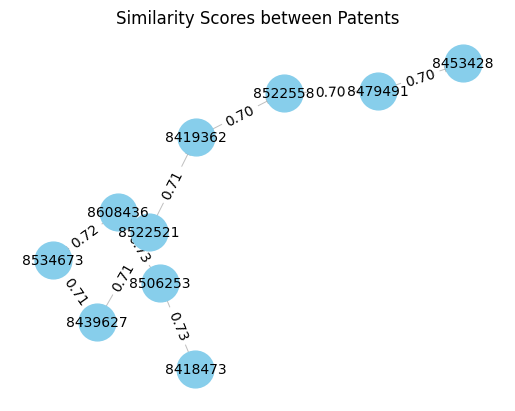

'\nBelow graph represents id as node and edge as similarity score.\nIt begines ploting graph from random points and take average similarity score as edge value between two consigutive nodes\n'

In [74]:
"""
this plot is showing similarity score between two ids of the top 10 score of the output.
showing the avg similarity score between two consecutive ids from output dataframe
"""
# This line initializes an empty directed graph (DiGraph) using the NetworkX library.
G = nx.DiGraph()

# Adding nodes and edges based on similarity scores
"""
This loop iterates over the top 10 records in k_similar_patents and adds nodes and edges to the graph
based on the patent information and similarity scores.Each node is labeled with information
about the patent, including its ID, CPC ID, and similarity score. Edges are added between consecutive patents
in the sorted list based on their similarity scores.
"""
for i in range(len(final_df)):
    patent_id = final_df.iloc[i]['id']
    cpc_id = final_df.iloc[i]['cpc_ids']
    similarity_score = final_df.iloc[i]['similarity_score']
    #plot to show final visuals
    G.add_node(patent_id, label=f"Patent {patent_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")

    # Connect nodes with directed edges based on similarity score
    if i > 0:
        previous_patent_id = final_df.iloc[i - 1]['id']
        G.add_edge(previous_patent_id, patent_id, weight=similarity_score)

# Draw the graph using a force-directed layout
"""
It generates positions of nodes using the force-directed layout algorithm (spring_layout)
provided by NetworkX. The pos variable now contains the 2D coordinates of each node.

"""
pos = nx.spring_layout(G)

# Extract edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Display edge weights on the graph
"""
These lines use the networkx drawing functions to visualize the nodes, edges, and labels
based on the generated layout (pos). Nodes are drawn with a size of 700, colored sky blue

"""
#These lines add labels to the edges, displaying their weights (similarity scores) on the graph.
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


# Show the graph
plt.title("Similarity Scores between Patents")
plt.axis("off")
plt.show()
"""
After running this script, the plt.show() command will display the resulting graph.
The positions of nodes in the visualization are determined
by the force-directed layout algorithm and will likely change each time you run
the script due to the random initialization of node positions.
"""

"""
Below graph represents id as node and edge as similarity score.
It begines ploting graph from random points and take average similarity score as edge value between two consigutive nodes
"""

1] Nodes are created for each patent using the patent_id as the node identifier. Edges are created from the "cpc_ids" node to each patent node with weights based on similarity scores.

2]It focus on the relationship between a general "cpc_ids" category and individual patents.

**3]A Directed Acyclic Graph (DAG) is a graph structure that consists of nodes (vertices) and directed edges. In a DAG, edges have a direction, meaning they go from one node to another, and there are no cycles, which means you cannot traverse a sequence of edges and return to the starting node. In other words, you can't have a closed loop in a DAG.**


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML

# Assuming df_claim_cpc_result is your DataFrame with columns "id", "cpc_ids", "similarity_score", "text"
k_similar_patents = final_df.nlargest(10, ['similarity_score'])

# Extracting necessary columns for visualization
data = k_similar_patents[['id', 'cpc_ids', 'similarity_score']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(data)):
    patent_id = data.iloc[i]['id']
    cpc_id = f"{patent_id}_{data.iloc[i]['cpc_ids']}"
    similarity_score = data.iloc[i]['similarity_score']

    G.add_node(cpc_id, label=f"Patent {patent_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")
    G.add_edge("F01D", cpc_id, value=similarity_score)

# Create a Pyvis network
pyvis_network = Network(notebook=True,cdn_resources='remote')
pyvis_network.from_nx(G)

# Save the Pyvis network as an HTML file
html_file_path = '/content/drive/MyDrive/patents/img5.html'
pyvis_network.show(html_file_path)

# Display the Pyvis network
pyvis_network.show(html_file_path)

# Display the web diagram in Colab
with open(html_file_path, 'r') as file:
    html_content = file.read()

HTML(html_content)


/content/drive/MyDrive/patents/img5.html
/content/drive/MyDrive/patents/img5.html


In [ ]:
# ! pip install pyvis

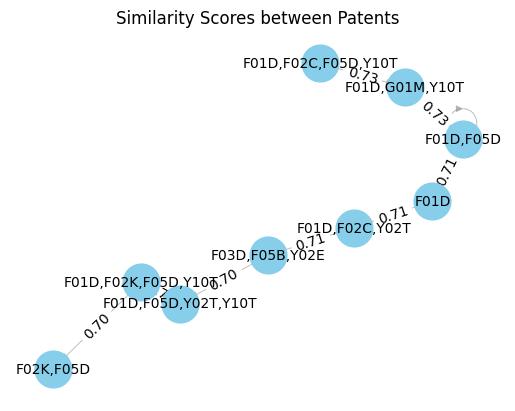

In [76]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(final_df)):
    patent_id = final_df.iloc[i]['id']
    cpc_id = final_df.iloc[i]['cpc_ids']
    similarity_score = final_df.iloc[i]['similarity_score']

    G.add_node(cpc_id, label=f"Patent {cpc_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")
    #creating a directed acyclic graph (DAG) where nodes represent patents and edges represent the
    #relationships between patents based on their similarity scores.

    # Connect nodes with directed edges based on similarity score
    if i > 0:
        previous_cpc_id = final_df.iloc[i - 1]['cpc_ids']
        G.add_edge(previous_cpc_id, cpc_id, weight=similarity_score)

# Draw the graph using a force-directed layout
pos = nx.spring_layout(G)

# Extract edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Display edge weights on the graph
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the graph
plt.title("Similarity Scores between Patents")
plt.axis("off")
plt.show()

In [77]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(final_df)):
    patent_id = final_df.iloc[i]['id']
    cpc_id = final_df.iloc[i]['cpc_ids']
    similarity_score = final_df.iloc[i]['similarity_score']

    G.add_node(cpc_id, label=f"Patent {cpc_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")
    #creating a directed acyclic graph (DAG) where nodes represent patents and edges represent the
    #relationships between patents based on their similarity scores.

    # Connect nodes with directed edges based on similarity score
    if i > 0:
        previous_cpc_id = final_df.iloc[i - 1]['cpc_ids']
        G.add_edge(previous_cpc_id, cpc_id, weight=similarity_score)

# Draw the graph using a force-directed layout
pos = nx.spring_layout(G)

# Extract edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# # Draw nodes, edges, and labels
# nx.draw_networkx_nodes(G, pos, node_size=300, node_color="yellow")
# nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="gray", alpha=0.5)
# nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Display edge weights on the graph
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Create a Pyvis network
pyvis_network = Network(notebook=True,cdn_resources='remote')
pyvis_network.from_nx(G)

# Save the Pyvis network as an HTML file
html_file_path = '/content/drive/MyDrive/patents/model6.html'
pyvis_network.show(html_file_path)

# # Display the Pyvis network
# pyvis_network.show(html_file_path)

# Display the web diagram in Colab
with open(html_file_path, 'r') as file:
    html_content = file.read()

HTML(html_content)
# # Show the graph
# plt.title("Similarity Scores between Patents")
# plt.axis("off")
# plt.show()





/content/drive/MyDrive/patents/model6.html


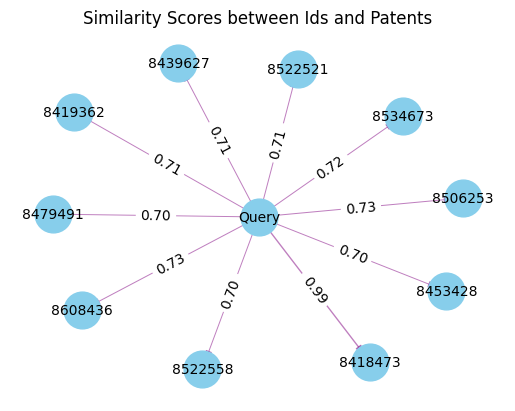

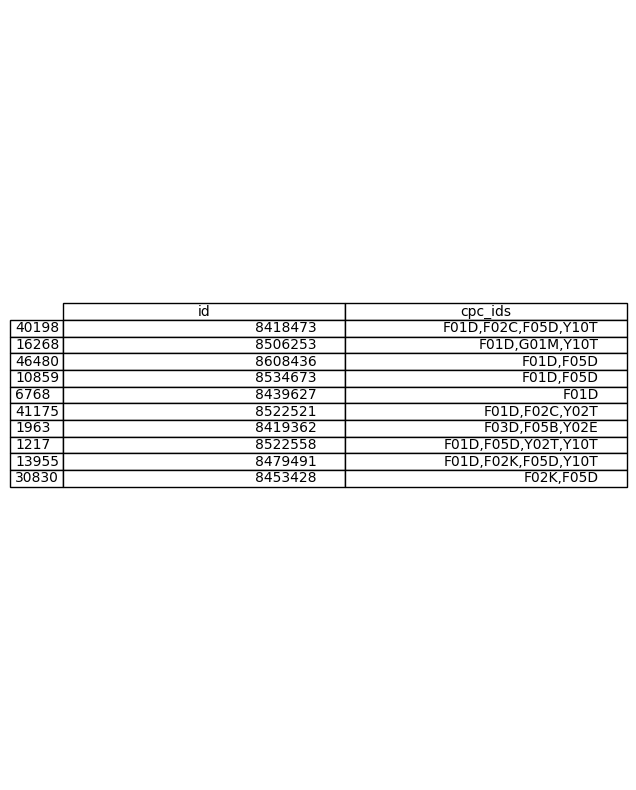

In [78]:
# Extracting necessary columns for visualization
data = final_df[['id', 'cpc_ids', 'similarity_score', 'text']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(data)):
    patent_id = data.iloc[i]['id']
    cpc_id = data.iloc[i]['cpc_ids']
    similarity_score = data.iloc[i]['similarity_score']
    sentence = data.iloc[i]['text']

    G.add_node(patent_id, label=f"Patent {patent_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")

    # # Connect nodes with directed edges based on similarity score
    G.add_edge("Query",patent_id, weight=similarity_score)

# Draw the graph using a force-directed layout
pos = nx.spring_layout(G)

# Extract edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="purple", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Display edge weights on the graph
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the graph
plt.title("Similarity Scores between Ids and Patents")
plt.axis("off")
plt.show()

# Plot table
plt.figure(figsize=(16,10))
ax1 = plt.subplot(121)
tbl = table(ax1, final_df[["id","cpc_ids"]], loc='center')
plt.axis('off')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)

#Below graph shows the similar sentance mathes id regarding to our query


In [79]:
# Extracting necessary columns for visualization

data = result_df.nlargest(10, ['similarity_score'])
data = final_df[['id', 'cpc_ids', 'similarity_score', 'text']]
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(data)):
    patent_id = data.iloc[i]['id']
    cpc_id = data.iloc[i]['cpc_ids']
    similarity_score = data.iloc[i]['similarity_score']
    sentence = data.iloc[i]['text']

    G.add_node(patent_id, label=f"Patent {patent_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")

    # # Connect nodes with directed edges based on similarity score
    G.add_edge("Query",patent_id, weight=similarity_score)

# Save the Pyvis network as an HTML file
html_file_path = '/content/drive/MyDrive/patents/model6.html'
# pyvis_network.show(html_file_path)

# Display the Pyvis network
pyvis_network.show(html_file_path)

# Display the web diagram in Colab
with open(html_file_path, 'r') as file:
    html_content = file.read()

HTML(html_content)
#Below graph shows the similar sentance mathes id regarding to our query


/content/drive/MyDrive/patents/model6.html


# **Save and Load The Embeddings For Pediction**

In [80]:
embeddings_file = '/content/drive/MyDrive/patents/sentence_embeddings.npy'

# Save all embeddings to a file
np.save(embeddings_file, sentence_embeddings)


In [81]:
# Load embeddings from the file for further use
sentence_embeddings = np.load(embeddings_file)

In [82]:
# take example for finding similar sentences
query_text = "A data processing system for modifying a query during compilation of the query, the query comprising a request for an element of data from a table in a database and parameters identifying the requested element, the data processing system comprising: a computer executing data processing, the computer comprising: an external system interface which: wherein based on determining that the external system does not know the requested data classification and the query associated classification, the suggested action comprises a request to call the external system again at execution time of the query for the requested data classification and the query associated classification, and wherein the external system is external to the computer and manages assignment of classifications to users and sections of data in the table."

# Encode the example text
query_embedding = model.encode(query_text)

In [83]:
# Use cosine similarity to find the most similar sentences
cosine_scores = util.pytorch_cos_sim(query_embedding, sentence_embeddings)[0]

In [84]:

# Create a DataFrame with 'id', 'text', and 'similarity_score' columns
result_df = pd.DataFrame({
    'id': patent_dataset['id'],
    'text': texts,
    'cpc_ids': patent_dataset['cpc_ids'],
    'similarity_score': cosine_scores.tolist()
})

# Sort the DataFrame by similarity scores in descending order
result_df= result_df.sort_values(by='similarity_score', ascending=False)

#gives 1 as output if example mathes 90% with dataset sentances otherwise 0
result_df['prediction'] = (result_df['similarity_score'] > 0.9).astype(int)

In [85]:
# Print the top 10 similar sentences from dataset wich is similar to example
top_n = 10
for i in range(top_n):
    print(f"Similarity Score: {result_df['similarity_score'].iloc[i]:.4f}")
    print(f"ID: {result_df['id'].iloc[i]}, Text: {result_df['text'].iloc[i]}\n")
    print("Prediction:", result_df['prediction'].iloc[i])

Similarity Score: 0.9880
ID: 8577906, Text: 1. A data processing system for modifying a query during compilation of the query, the query comprising a request for an element of data from a table in a database and parameters identifying the requested element, the data processing system comprising: a computer executing data processing, the computer comprising: an external system interface which: wherein based on determining that the external system does not know the requested data classification and the query associated classification, the suggested action comprises a request to call the external system again at execution time of the query for the requested data classification and the query associated classification, and wherein the external system is external to the computer and manages assignment of classifications to users and sections of data in the table.

Prediction: 1
Similarity Score: 0.8224
ID: 8416666, Text: 1. A data processing system, the data processing system comprising: a d

In [86]:
# top 10 similarity score
final_result_df = result_df.nlargest(10,['similarity_score'])

In [87]:
final_result_df

,id,text,cpc_ids,similarity_score,prediction
500,8577906,1. A data processing system for modifying a qu...,G06F,0.987956,1
34373,8416666,"1. A data processing system, the data processi...",G11B,0.822428,0
14871,8402348,"1. A data processing system, the system compri...","G06F,H03M",0.804161,0
13729,8525707,"1. A data processing system, the data processi...",H03M,0.801636,0
39005,8522120,"1. A data processing system, the system compri...",H03M,0.785829,0
32257,8498073,"1. A data processing system, the system compri...",G11B,0.784013,0
1825,8578253,"1. A data processing circuit, the system compr...","G11B,H03M",0.758183,0
40252,8570556,1. An image processing system to perform image...,H04N,0.754805,0
986,8402001,1. A system comprising: a query processor for ...,G06F,0.750503,0
36375,8346815,1. A system comprising: a data processing appa...,G06F,0.748408,0


In [89]:
# ! pip install pyviz

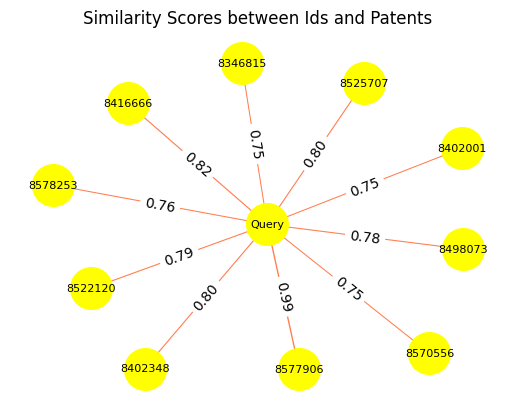

In [88]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(final_result_df)):
    patent_id = final_result_df.iloc[i]['id']
    cpc_id = final_result_df.iloc[i]['cpc_ids']
    similarity_score = final_result_df.iloc[i]['similarity_score']
    sentence = final_result_df.iloc[i]['text']

    G.add_node(patent_id, label=f"Patent {patent_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")

    # # Connect nodes with directed edges based on similarity score
    G.add_edge("Query",patent_id, weight=similarity_score)

# Draw the graph using a force-directed layout
pos = nx.spring_layout(G)

# Extract edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=900, node_color="yellow")
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="coral", alpha=1)
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

# Display edge weights on the graph
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the graph
plt.title("Similarity Scores between Ids and Patents")
plt.axis("off")
plt.show()

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML

# Assuming df_claim_cpc_result is your DataFrame with columns "id", "cpc_ids", "similarity_score", "text"
k_similar_patents = final_result_df.nlargest(10, ['similarity_score'])

# Extracting necessary columns for visualization
data = k_similar_patents[['id', 'cpc_ids', 'similarity_score']]

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on similarity scores
for i in range(len(data)):
    patent_id = data.iloc[i]['id']
    cpc_id = f"{patent_id}_{data.iloc[i]['cpc_ids']}"
    similarity_score = data.iloc[i]['similarity_score']

    G.add_node(cpc_id, label=f"Patent {patent_id}\nCPC {cpc_id}\nSimilarity {similarity_score:.4f}")
    G.add_edge("F01D", cpc_id, value=similarity_score)

# Create a Pyvis network
pyvis_network = Network(notebook=True,cdn_resources='remote')
pyvis_network.from_nx(G)

# Save the Pyvis network as an HTML file
html_file_path = '/content/drive/MyDrive/patents/img5.html'
pyvis_network.show(html_file_path)

# Display the Pyvis network
pyvis_network.show(html_file_path)

# Display the web diagram in Colab
with open(html_file_path, 'r') as file:
    html_content = file.read()

HTML(html_content)


/content/drive/MyDrive/patents/img5.html
/content/drive/MyDrive/patents/img5.html


# Evaluation by using MRR-Scrore


In [91]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_mrr(query_embeddings, sentence_embeddings, relevance_threshold=0.5):
    mrr_sum = 0.0
    num_queries = len(query_embeddings)  # Fix variable name

    for i in range(num_queries):
        query_embedding = np.array(query_embeddings[i]).reshape(1, -1)  # Ensure query_embedding is 2D

        similarities = [cosine_similarity(query_embedding, np.array(candidate_embedding).reshape(1, -1))[0, 0] for candidate_embedding in sentence_embeddings]
        ranked_indices = sorted(range(len(similarities)), key=lambda k: similarities[k], reverse=True)

        # Find the rank of the first relevant sentence
        rank_of_first_relevant = next((rank + 1 for rank, idx in enumerate(ranked_indices) if similarities[idx] > relevance_threshold), None)

        # If no relevant sentence is found, set rank to the maximum rank + 1
        rank = rank_of_first_relevant if rank_of_first_relevant is not None else len(similarities) + 1

        # Compute reciprocal rank
        reciprocal_rank = 1 / rank
        mrr_sum += reciprocal_rank

    # Compute average MRR
    mrr = mrr_sum / num_queries
    return mrr


my_query_embeddings = [query_embedding]  # Assuming query_embedding is defined
query_embeddings = np.array(my_query_embeddings).reshape(1, -1)

relevance_threshold = 0.5

mrr = compute_mrr(query_embeddings, sentence_embeddings, relevance_threshold)
print(f"MRR: {mrr:.4f}")

MRR: 1.0000
